In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import numpy.ma as ma
import cartopy.crs as ccrs

In [2]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

In [3]:
import plot_topView_contourf as topView
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

<IPython.core.display.Javascript object>


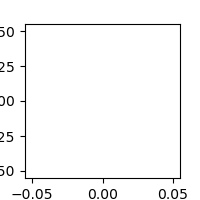

In [59]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

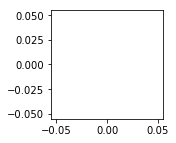

In [63]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
winds = []
with open("../../../Winds/list_files.txt") as file_list:
    for line in file_list:
        winds.append(xr.open_dataset("../../../Winds/ERA_interim/"+line.split("\n")[0]))

In [3]:
winds = xr.open_mfdataset("../../../Winds/ERA_interim/*.nc")

In [4]:
winds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 168)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<shape=(168, 241, 480), chunksize=(12, 241, 480)>
    v10        (time, latitude, longitude) float32 dask.array<shape=(168, 241, 480), chunksize=(12, 241, 480)>
    iews       (time, latitude, longitude) float32 dask.array<shape=(168, 241, 480), chunksize=(12, 241, 480)>
    inss       (time, latitude, longitude) float32 dask.array<shape=(168, 241, 480), chunksize=(12, 241, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-09-18 06:09:01 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

In [4]:
windsMergedSH = winds.sel(latitude=slice(-60, -89.25))

In [68]:
windsMergedSH.u10.values.shape

(168, 40, 480)

In [69]:
np.zeros_like(windsMergedSH.u10).shape

(168, 40, 480)

In [5]:
def compute_stress_curl(windsMergedSH):
    stress_curl = np.zeros_like(windsMergedSH.u10)
    wek = np.zeros_like(windsMergedSH.u10)
    rho0 = 1025
    tauy_x = np.zeros_like(windsMergedSH.u10)
    taux_y = np.zeros_like(windsMergedSH.u10)
    
    delta_lat = abs(float(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    delta_lon = abs(float(windsMergedSH.longitude[0] - windsMergedSH.longitude[1]))
    r = 6371e3 # radius of earth in metres
    dy = float(r * np.deg2rad(windsMergedSH.latitude[0] - windsMergedSH.latitude[1]))
    omega = 2*np.pi/(24.*3600)
    f = 2. * omega * np.sin(np.deg2rad(windsMergedSH.latitude.values))
    time_counter = 0
    for t in windsMergedSH.time:
    
        lat_counter = 0
        for lat in windsMergedSH.latitude:
            
            dx = float(r * np.cos(np.deg2rad(lat) ) * delta_lon)
        
            tauy_x[time_counter, lat_counter] = np.gradient(windsMergedSH.sel(time = t, latitude=lat).inss , dx)
            lat_counter+=1
        _, taux_y[time_counter] = np.gradient(windsMergedSH.sel(time = t).iews , dx, dy)
        stress_curl[time_counter] = tauy_x[time_counter] - taux_y[time_counter]
        
        for l in range(len(windsMergedSH.latitude)):
            wek[time_counter, l] = stress_curl[time_counter, l] / (f[l] * rho0)
        time_counter += 1
    
    
    windEk = xr.Dataset({'stressCurl':(['time', 'latitude', 'longitude'], stress_curl), 
                         'wek':(['time', 'latitude', 'longitude'], wek) }, 
                        coords={'time': windsMergedSH.time, 'latitude': windsMergedSH.latitude, 
                               'longitude': windsMergedSH.longitude})
    return windEk

In [6]:
windEk = compute_stress_curl(windsMergedSH)

KeyboardInterrupt: 

In [30]:
windEk.to_netcdf("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc")

In [12]:
!ls -lrtsh /media/data/Datasets/Winds/

total 25M
4.0K drwxrwxrwx 2 km km 4.0K Sep 20  2018 ERA_interim
4.0K -rwxrwxrwx 1 km km  294 Sep 20  2018 list_files.txt
 25M -rw-r--r-- 1 km km  25M Apr  6 17:09 wek_ERA_interim_2004_2017.nc


In [7]:
windEk = xr.open_dataset("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc",)

In [7]:
import plot_bathymetryGradients as pbgrad
importlib.reload(pbgrad)

<module 'plot_bathymetryGradients' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathymetryGradients.py'>

In [8]:
bathy_gradient = pbgrad.compute_bathymetryGradients(lonstep=5, latstep=1)

In [9]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [10]:
lonlen = len(bathy.lon)
lonindices = np.arange(0, lonlen+1, 5) # lonstep=5, every 5th longitude
lonindices[-1] = lonindices[-1] - 1
bathyS = bathy.isel(lon=lonindices, lat=np.arange(0, 3600, 1))

In [11]:
bathy_gradient = ma.masked_array(np.array(bathy_gradient))
bathy_gradient.mask = (bathy_gradient < 0.002) | (bathyS.elevation < -3500) | (bathyS.elevation > -800)

In [12]:
bathyS['bathy_gradient'] = (['lat', 'lon'], bathy_gradient)

In [13]:
bathyS['bathy_gradient_mask'] = (['lat', 'lon'], bathy_gradient.mask)

In [8]:
bathyS = xr.open_dataset("/media/hdd2/SOSE_1_12/bathyS.nc")

In [9]:
slopeLonLatLims = np.array([ [-50.,-25., -75, -71] , [-25, -5, -80, -65], [-5, 0, -85, -67.6], 
                            [0,8, -85, -67.6], [8,46.9832, -80, -60], [46.9832, 48.3, -66.7, -60],
                            [48.3, 49.118, -80, -60], [49.118, 50.139, -66.455, -60], [50.139, 57.4, -80, -60],
                            [57.4, 58.9, -66.47, -60],[58.9, 59.68, -66.7, -60], [59.68, 60, -80, -60],
                            [60, 61.5, -66.85, -60], [61.5, 64, -80, -60], [64, 66, -67.1, -60],
                            [66, 79.4, -67.5, -63.5], [79.4, 81.5, -66.7, -64], [81.5, 89.68, -80, -64],
                            [89.68, 92.5, -65.8, -60], [92.5, 92.7, -80, -60], [92.7, 101, -65.1, -60],
                            [101, 103, -65, -60], [103, 105, -80, -60], [105, 109.5, -65.5, -60],
                            [109.5, 113, -65.9, -60], [113, 115, -65.47, -60], [115, 122, -80, -60], 
                            [122, 126, -66, -60], [126, 134, -65.3, -63], [134, 135, -65, -63],
                            [135, 148.6, -66.25, -63], [148.6, 152, -80, -65], [152, 155, -80, -65.5],
                            [155, 160, -80, -66], [160, 170, -73, -68.5], [170, 180, -73.6, -68.5],
                            [-180, -170, -80, -70], [-170, -160, -80, -73],
                            [-160, -151.3, -76.6, -73], [-151.3, -148.7, -76, -73], [-148.7, -140, -80, -73],
                            [-140, -136, -74.38, -71], [-136, -132, -74.3, -71], [-132, -130, -73.9, -71],
                            [-130, -120, -73.26, -70], [-120, -110, -72.8, -70], [-110, -100, -72, -70],
                            [-100, -90, -71.6, -69.3], [-90, -80, -71, -67.8], [-80, -75, -69.5, -65],
                            [-75, -72, -68.4, -65], [-72, -70, -67.6, -65], [-70, -68, -66.2, -63],
                            [-68, -66, -65, -63], [-66, -64, -64, -62.7], [-64, -62.37, -63.1, -61.86],
                            [-62.37, -62, -62.7, -61.86], [-62, -60, -62.55, -61], [-60, -58, -62, -60.8],
                            [-58, -56, -61.5, -60.6],
                            [-56, -50, -80, -60]] )

In [10]:
slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] = slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] + 360
slopeLonLatLims[2][1] = 360
slopeLonLatLims[:, :]

array([[310.    , 335.    , -75.    , -71.    ],
       [335.    , 355.    , -80.    , -65.    ],
       [355.    , 360.    , -85.    , -67.6   ],
       [  0.    ,   8.    , -85.    , -67.6   ],
       [  8.    ,  46.9832, -80.    , -60.    ],
       [ 46.9832,  48.3   , -66.7   , -60.    ],
       [ 48.3   ,  49.118 , -80.    , -60.    ],
       [ 49.118 ,  50.139 , -66.455 , -60.    ],
       [ 50.139 ,  57.4   , -80.    , -60.    ],
       [ 57.4   ,  58.9   , -66.47  , -60.    ],
       [ 58.9   ,  59.68  , -66.7   , -60.    ],
       [ 59.68  ,  60.    , -80.    , -60.    ],
       [ 60.    ,  61.5   , -66.85  , -60.    ],
       [ 61.5   ,  64.    , -80.    , -60.    ],
       [ 64.    ,  66.    , -67.1   , -60.    ],
       [ 66.    ,  79.4   , -67.5   , -63.5   ],
       [ 79.4   ,  81.5   , -66.7   , -64.    ],
       [ 81.5   ,  89.68  , -80.    , -64.    ],
       [ 89.68  ,  92.5   , -65.8   , -60.    ],
       [ 92.5   ,  92.7   , -80.    , -60.    ],
       [ 92.7   , 10

In [11]:
windsMergedSH

<xarray.Dataset>
Dimensions:    (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
  * time       (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    v10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    iews       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    inss       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-09-18 06:09:01 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

In [12]:
#slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] = slopeLonLatLims[:, 0:2][slopeLonLatLims[:, 0:2] < 0] + 360
#slopeLonLatLims[2][1] = 360

slopeMask = np.zeros(windsMergedSH.sel(time = 0, method="nearest").u10.shape, dtype=bool)
for i in range(len(slopeLonLatLims)):
    slopeMask = slopeMask + ~np.isnan(windsMergedSH.isel(time=0).u10.where\
                                        (windsMergedSH.longitude >= slopeLonLatLims[i][0]).where\
                                        (windsMergedSH.longitude <= slopeLonLatLims[i][1]).where\
                                        (windsMergedSH.latitude >= slopeLonLatLims[i][2]).where\
                                        (windsMergedSH.latitude <= slopeLonLatLims[i][3]).values)

windlons = windsMergedSH.longitude.values
windlons[windlons > 180] = windlons[windlons > 180] - 360
windlats = windsMergedSH.latitude.values

bathyGradMask = bathyS.sel(lon= windlons, lat=windsMergedSH.latitude, method='nearest').bathy_gradient_mask.values
#del(bathyS)


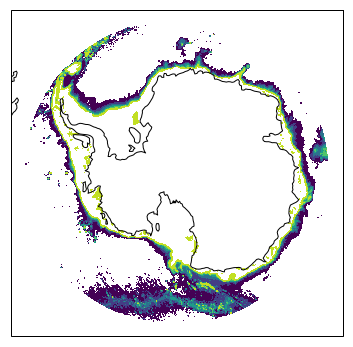

In [23]:
plt.close(1)
plt.figure(1, figsize=(6,6))
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0) )

lons = bathyS.lon
lats = bathyS.lat
elev = bathyS.elevation.where(~bathyS.bathy_gradient_mask)

mapax.contourf(lons, lats, elev, vmin=-3000, vmax=-800, extend='both', transform= ccrs.PlateCarree())
mapax.coastlines()

plt.show()

In [68]:
monthlyMeanZonal

<xarray.DataArray 'u10' (month: 12, latitude: 40, longitude: 480)>
dask.array<shape=(12, 40, 480), dtype=float32, chunksize=(1, 40, 480)>
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

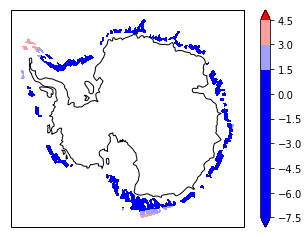

In [19]:
plt.close(1)
plt.figure(1)
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0) )

lons = windsMergedSH.longitude.values
lats = windsMergedSH.latitude.values

monthlyMeanZonal = windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).u10.\
                                                       where(~bathyGradMask & slopeMask).sel(month=3)

CF = mapax.contourf(lons, lats, monthlyMeanZonal, cmap='bwr', vmin=1, vmax=5, extend='both',
                     transform= ccrs.PlateCarree())
mapax.coastlines()

plt.colorbar(CF)
plt.show()

In [72]:
windsMergedSH

<xarray.Dataset>
Dimensions:    (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
  * time       (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    v10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    iews       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    inss       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-09-18 06:09:01 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


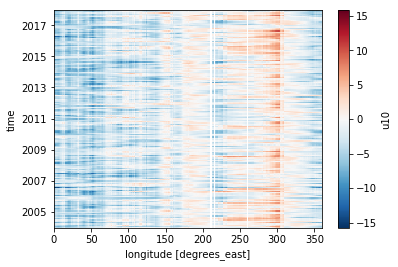

In [13]:
windsMergedSH.where(~bathyGradMask & slopeMask).u10.mean(dim='latitude').plot()

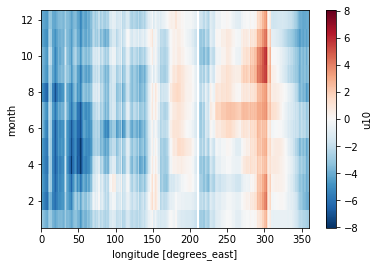

In [14]:
windsMergedSH.where(~bathyGradMask & slopeMask).u10.mean(dim='latitude').groupby(windsMergedSH.time.dt.month).\
mean(dim='time').plot()

In [ ]:
windsMergedSH

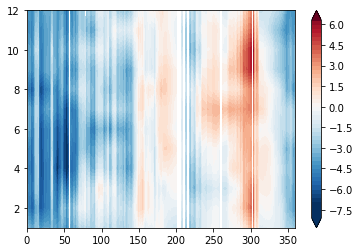

In [71]:
plt.close(1)
plt.figure(1)
ax = plt.subplot()

monthlyMeanZonal = windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).u10.\
                                                       where(~bathyGradMask & slopeMask).mean(dim=['latitude'])
CF = ax.contourf(monthlyMeanZonal.longitude, monthlyMeanZonal.month, monthlyMeanZonal, 50, cmap='RdBu_r', 
             vmin=-7, vmax=7, extend='both')
#lonticks = monthlyMeanZonal.longitude.values
#ax.set_xticks(lonticks[:])
#lonlabels = lonticks
#lonlabels[lonlabels > 180] = lonlabels[lonlabels > 180] - 360
#ax.set_xticklabels(np.array(lonlabels[:], dtype=str))
plt.colorbar(CF)
plt.show()

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


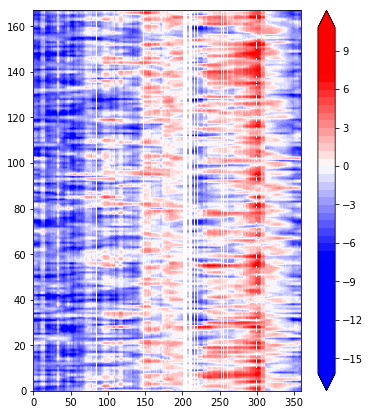

In [22]:
plt.close(1)
plt.figure(1, figsize=(6, 7))
ax = plt.subplot()
timeAxis = windsMergedSH.where(~bathyGradMask & slopeMask ).u10.mean(dim=['latitude']).time
lonAxis = windsMergedSH.where(~bathyGradMask & slopeMask).u10.mean(dim=['latitude']).longitude

zonalWind = windsMergedSH.where(~bathyGradMask & slopeMask).u10.mean(dim=['latitude'])

CF = ax.contourf(lonAxis, np.arange(len(timeAxis)), zonalWind, 50, cmap='bwr', vmin=-7, vmax=7, extend='both')

plt.colorbar(CF)
plt.show()

In [ ]:
windEk.groupby(windEk.time.dt.month).mean(dim=['time']).wek.\
               where(~bathyGradMask & regionSlopeMask).mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', 
                                                                         cmap='bwr')

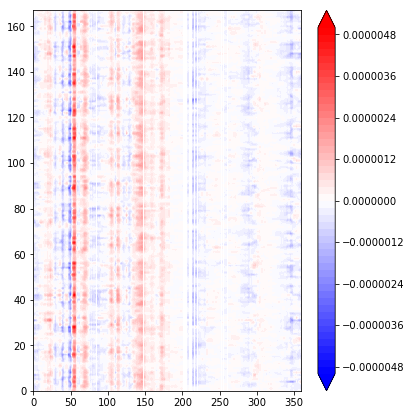

In [26]:
plt.close(1)
plt.figure(1, figsize=(6, 7))
ax = plt.subplot()

wek_LatMean = windEk.where(~bathyGradMask & slopeMask).wek.mean(dim=['latitude'])

timeAxis = wek_LatMean.time
lonAxis = wek_LatMean.longitude

CF = ax.contourf(lonAxis, np.arange(len(timeAxis)), wek_LatMean, 50, cmap='bwr', vmin=-5e-6, vmax=5e-6, extend='both')

plt.colorbar(CF)
plt.show()

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


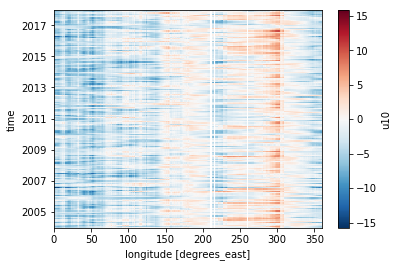

In [27]:
windsMergedSH.u10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

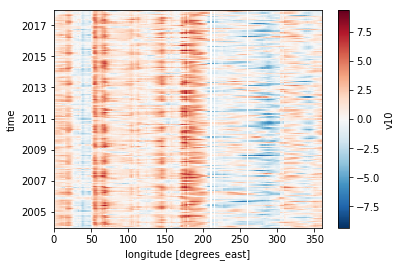

In [28]:
windsMergedSH.v10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

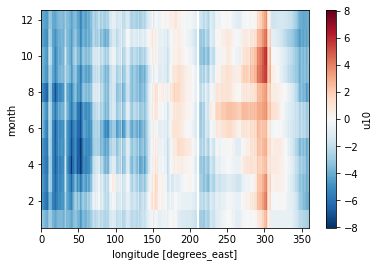

In [29]:
windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).\
u10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

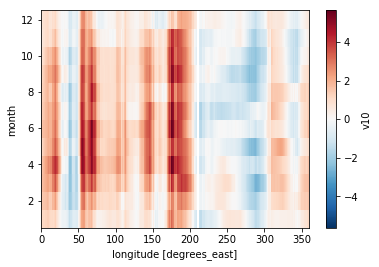

In [30]:
windsMergedSH.groupby(windsMergedSH.time.dt.month).mean(dim=['time']).\
v10.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot()

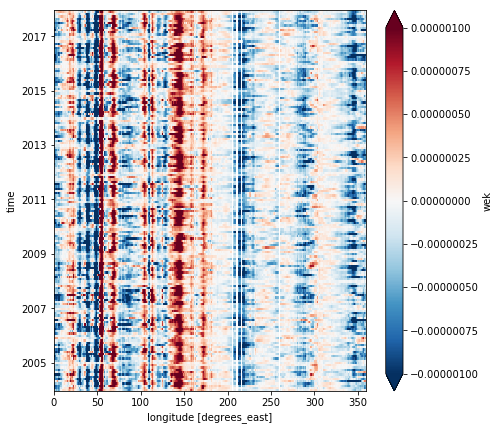

In [50]:
windEk.wek.where(~bathyGradMask & slopeMask).mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', 
                                                                         cmap='RdBu_r', figsize=(7,7))

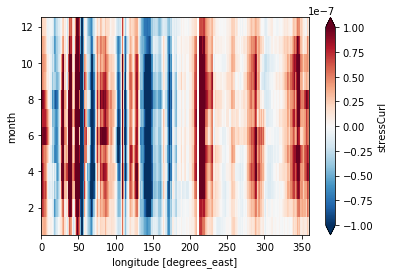

In [53]:
windEk.where(~bathyGradMask & slopeMask).groupby(windEk.time.dt.month).mean(dim=['time']).stressCurl\
.mean(dim=['latitude']).plot(vmin=-1e-7, vmax=1e-7, extend='both', cmap='RdBu_r')

In [15]:
windEk

<xarray.Dataset>
Dimensions:     (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude   (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * time        (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
  * latitude    (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
Data variables:
    stressCurl  (time, latitude, longitude) float32 ...
    wek         (time, latitude, longitude) float32 ...

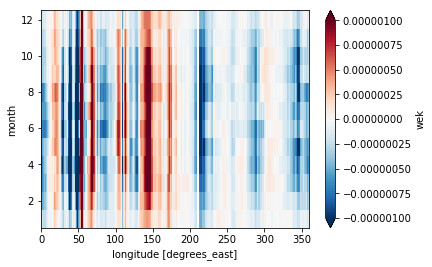

In [65]:
windEk.where(~bathyGradMask & slopeMask).groupby(windEk.time.dt.month).mean(dim=['time']).wek\
.mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', cmap='RdBu_r')

In [30]:
windlons = windsMergedSH.longitude.values
windlons[windlons > 180] = windlons[windlons > 180] - 360
windlats = windsMergedSH.latitude.values

bathySwindlons = bathyS.sel(lon= windlons, lat=windsMergedSH.latitude, method='nearest')
shelfSelMask = ~np.isnan(bathySwindlons.where((bathySwindlons.elevation < 0) & (bathySwindlons.elevation > -1000) ).\
                        elevation.values)

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


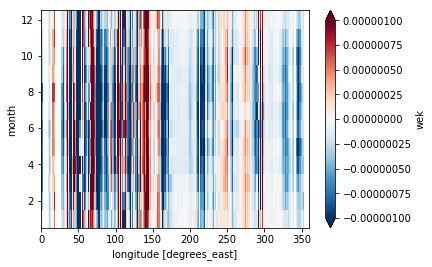

In [32]:
windEk.where(shelfSelMask).groupby(windEk.time.dt.month).mean(dim=['time']).wek\
.mean(dim=['latitude']).plot(vmin=-1e-6, vmax=1e-6, extend='both', cmap='RdBu_r')

In [28]:
windsMergedSH

<xarray.Dataset>
Dimensions:    (latitude: 40, longitude: 480, time: 168)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 -60.0 -60.75 -61.5 ... -87.75 -88.5 -89.25
  * time       (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2017-12-01
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    v10        (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    iews       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
    inss       (time, latitude, longitude) float32 dask.array<shape=(168, 40, 480), chunksize=(12, 40, 480)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-09-18 06:09:01 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

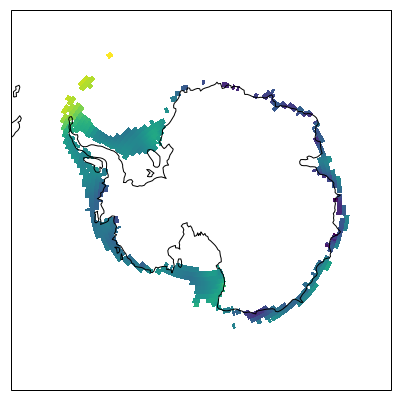

In [31]:
plt.close(1)
plt.figure(1, figsize=(7,7) )
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )
mapax.pcolormesh(windsMergedSH.longitude, windsMergedSH.latitude, 
                 windsMergedSH.sel(time=0, method='nearest').u10.where(shelfSelMask), 
                 transform=ccrs.PlateCarree())

mapax.coastlines()
plt.show()

In [17]:
bathyS.elevation

<xarray.DataArray 'elevation' (lat: 3600, lon: 8641)>
[31107600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 ... -60.02 -60.01 -60.0
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

<IPython.core.display.Javascript object>


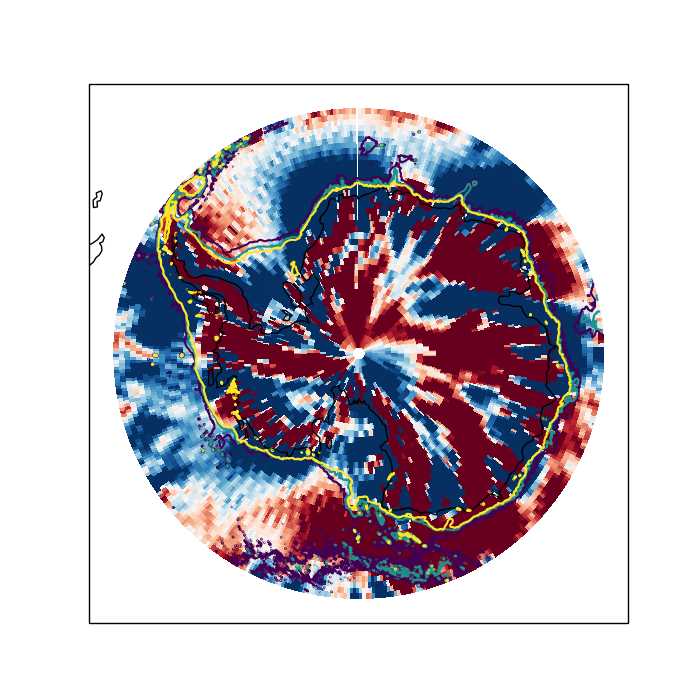

In [62]:
plt.close(1)
plt.figure(1, figsize=(7,7))

mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

plotfield = windEk.wek.mean(dim=['time'])
mapax.pcolormesh(plotfield.longitude, plotfield.latitude, plotfield, vmin=-1e-7, vmax=1e-7, 
                    cmap='RdBu_r', transform = ccrs.PlateCarree() )
mapax.coastlines()
mapax.contour(bathyS.lon, bathyS.lat, bathyS.elevation, levels=[-3000, -2000, -1000], transform = ccrs.PlateCarree())

plt.show()